Error fetching sector for ABC: 'str' object has no attribute 'get'
Error fetching sector for ADS: 'str' object has no attribute 'get'
Error fetching sector for AET: 'str' object has no attribute 'get'
Error fetching sector for AGN: 'str' object has no attribute 'get'
Error fetching sector for ALXN: 'str' object has no attribute 'get'
Error fetching sector for ANDV: 'str' object has no attribute 'get'
Error fetching sector for ANTM: 'str' object has no attribute 'get'
Error fetching sector for APC: 'str' object has no attribute 'get'
Error fetching sector for ARNC: 'str' object has no attribute 'get'
Sector performance data loaded successfully!
Web Data Loaded Successfully!
Web Data Cleaned Successfully!
Datasets Merged Successfully!


C:\Users\priya\AppData\Local\Temp\ipykernel_33628\2507003106.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df_merged.fillna("N/A", inplace=True)


Final Dataset Cleaned Successfully!
Final Cleaned Stock Market Data:


,Date,Open,High,Low,Close,Volume,Ticker,Sector,Percentage Change,Market Weight,YTD Return
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,Industrials,0.74175%,8.25%,0.59
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,Industrials,0.74175%,8.25%,0.59
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,Industrials,0.74175%,8.25%,0.59
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,Industrials,0.74175%,8.25%,0.59
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,Industrials,0.74175%,8.25%,0.59
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,Industrials,0.74175%,8.25%,0.59
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL,Industrials,0.74175%,8.25%,0.59
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL,Industrials,0.74175%,8.25%,0.59
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL,Industrials,0.74175%,8.25%,0.59
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL,Industrials,0.74175%,8.25%,0.59


                  Date   Open   High    Low  Close    Volume Ticker  \
0  2013-02-08 00:00:00  15.07  15.12  14.63  14.75   8407500    AAL   
1  2013-02-11 00:00:00  14.89  15.01  14.26  14.46   8882000    AAL   
2  2013-02-12 00:00:00  14.45  14.51  14.10  14.27   8126000    AAL   
3  2013-02-13 00:00:00  14.30  14.94  14.25  14.66  10259500    AAL   
4  2013-02-14 00:00:00  14.94  14.96  13.16  13.99  31879900    AAL   

        Sector Percentage Change Market Weight  YTD Return  
0  Industrials          0.74175%         8.25%        0.59  
1  Industrials          0.74175%         8.25%        0.59  
2  Industrials          0.74175%         8.25%        0.59  
3  Industrials          0.74175%         8.25%        0.59  
4  Industrials          0.74175%         8.25%        0.59  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Sector',
       'Percentage Change', 'Market Weight', 'YTD Return'],
      dtype='object')


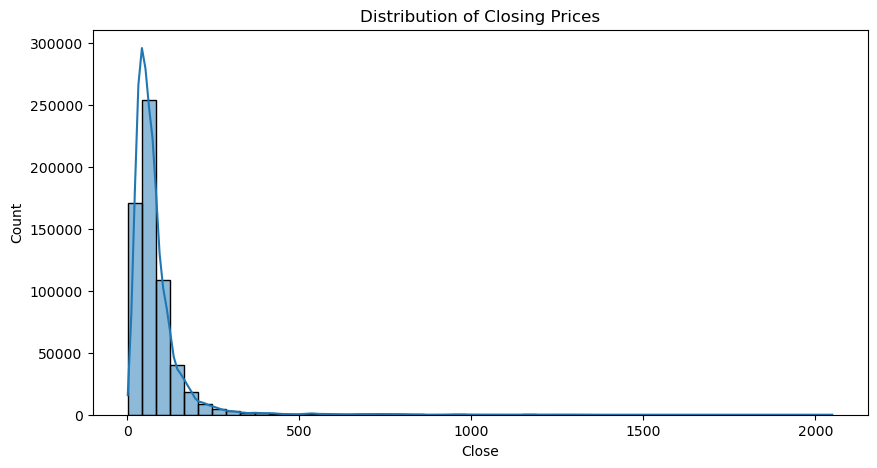

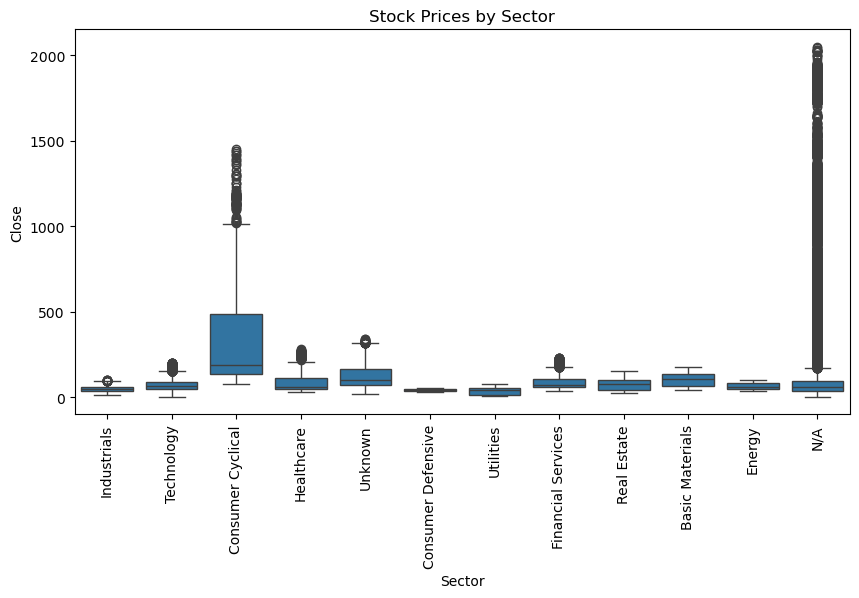

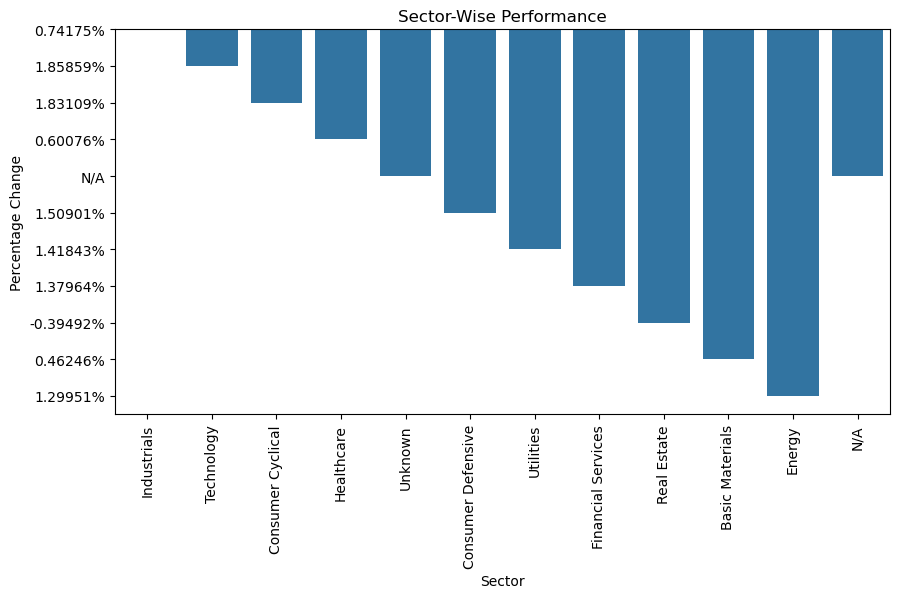

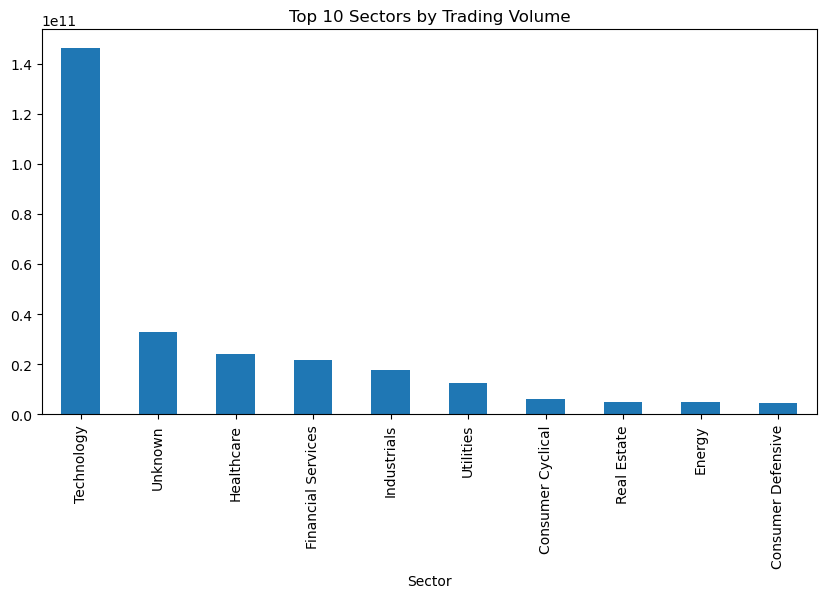

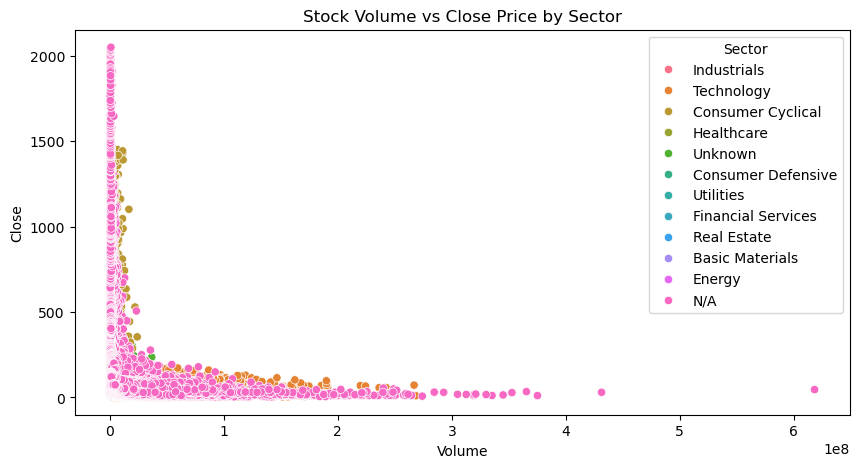

Data Processing Completed Successfully!


In [23]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
from yahooquery import Ticker
from fuzzywuzzy import process
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

""" Class to perform the stock market data processing. This class will extract the dataset from Kaggle and populate the sector name for the Ticker name by calling Yahoo Query. AS
there is some API limitage with this free version, I am switching it between yfinane and Alpha Vantage API and yahoo query. Additionaly we are pulling the dataset of sector wise
performance by calling the API financialmodelingprep and this also has API hit limit. For the Milestore4 we are also doing the additioanly formating to the  webscraping of data from
finance and cleaning data and we are also printing the 50 data with the HTML formatFor milestone5 we are storing the data into SQLlite database and then once the dataset is merged we are 
using the 5 different visualization and determining the top performing sectors in stock market"""
class StockMarketDataProcessor:
    def __init__(self, kaggle_file_path, fmp_api_key, db_path):
        self.kaggle_file_path = kaggle_file_path
        self.fmp_api_key = fmp_api_key
        self.df_kaggle = None
        self.df_api = None
        self.df_web = None
        self.db_path = db_path
        self.df_merged = None
        self.database_merged = None
        self.conn = sqlite3.connect(self.db_path)

    def load_kaggle_data(self):
        """Loads Kaggle dataset and cleans basic formatting."""
        self.df_kaggle = pd.read_csv(self.kaggle_file_path)
        self.df_kaggle.rename(columns={
            "date": "Date", "open": "Open", "high": "High",
            "low": "Low", "close": "Close", "volume": "Volume", "Name": "Ticker"
        }, inplace=True)
        self.df_kaggle["Date"] = pd.to_datetime(self.df_kaggle["Date"])
        self.df_kaggle["Ticker"] = self.df_kaggle["Ticker"].str.upper()
        self.df_kaggle.drop_duplicates(inplace=True)
        self.df_kaggle.dropna(inplace=True)
    
    def get_sector_from_yahooquery(self, ticker):
        """ Fetch sector information using Yahoo Query."""
        try:
            stock = Ticker(ticker)
            sector_info = stock.asset_profile.get(ticker, {}).get("sector", "Unknown")
            return sector_info
        except Exception as e:
            print(f"Error fetching sector for {ticker}: {e}")
            return "Unknown"
    
    def enrich_kaggle_with_sectors(self):
        """ Adds sector information to Kaggle dataset using Yahoo Query. """
        unique_tickers = self.df_kaggle["Ticker"].unique()
        sector_mapping = {ticker: self.get_sector_from_yahooquery(ticker) for ticker in unique_tickers[:50]}
        self.df_kaggle["Sector"] = self.df_kaggle["Ticker"].map(sector_mapping)
    
    def load_api_data(self):
        """ Fetches sector-wise performance metrics from Financial Modeling Prep API."""
        url = f"https://financialmodelingprep.com/api/v3/sectors-performance?apikey={self.fmp_api_key}"
        response = requests.get(url)
        
        if response.status_code == 200:
            sector_data = response.json()
            if isinstance(sector_data, list) and len(sector_data) > 0:
                self.df_api = pd.DataFrame(sector_data)
                self.df_api.rename(columns={"sector": "Sector", "changesPercentage": "Percentage Change"}, inplace=True)
                print("Sector performance data loaded successfully!")
            else:
                print("No sector performance data found!")
        else:
            print("Error fetching sector performance data:", response.status_code)
    
    def load_web_data(self):
        """Scrapes Yahoo Finance for sector performance data."""
        url = "https://finance.yahoo.com/sectors"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers)
    
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code}")
            return
    
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find("table")
    
        if table is None:
            print("Error: Could not find a table on Yahoo Finance page.")
            return
    
        headers = [header.text.strip() for header in table.find_all("th")]
        rows = [[col.text.strip() for col in row.find_all("td")] for row in table.find_all("tr")[1:]]
    
        self.df_web = pd.DataFrame(rows, columns=headers)
        print("Web Data Loaded Successfully!")
    
    def clean_web_data(self):
        """Cleans and transforms Yahoo Finance scraped data for all sectors."""
        if self.df_web is None or self.df_web.empty:
            print("No sector data available to clean.")
            return
    
        self.df_web.replace({"--": np.nan, "N/A": np.nan}, inplace=True)
        percentage_cols = [col for col in self.df_web.columns if "Return" in col]
    
        if percentage_cols:
            for col in percentage_cols:
                if col in self.df_web.columns:
                    self.df_web[col] = (
                        self.df_web[col]
                        .astype(str)
                        .str.replace("%", "", regex=True)
                        .astype(float, errors="ignore")
                    )
        self.df_web.drop_duplicates(inplace=True)
        self.df_web["Sector"] = self.df_web["Sector"].str.title().str.strip()
        print("Web Data Cleaned Successfully!")
        
        
    def merge_datasets(self):
        """ Merges Kaggle, API, and Web data on Sector."""
        self.df_merged = self.df_kaggle.copy()
        
        if self.df_api is not None and not self.df_api.empty:
            self.df_merged = pd.merge(self.df_merged, self.df_api, on="Sector", how="left")
        
        if self.df_web is not None and not self.df_web.empty:
            self.df_merged = pd.merge(self.df_merged, self.df_web, on="Sector", how="left")
        
        print("Datasets Merged Successfully!")

    def store_data_in_database(self):
        #Renaming it for duplicate ambiguity
        #self.df_api.rename(columns={"Sector": "Sector_API"}, inplace=True)
        #self.df_web.rename(columns={"Sector": "Sector_Web"}, inplace=True)

        self.df_kaggle.to_sql("kaggle_data", self.conn, if_exists="replace", index=False)
        if self.df_api is not None:
            self.df_api.to_sql("api_data", self.conn, if_exists="replace", index=False)
        if self.df_web is not None:
            self.df_web.to_sql("web_data", self.conn, if_exists="replace", index=False)
    
    
    def clean_final_dataset(self):
        """Final cleaning and formatting of the merged dataset."""
        if self.df_merged is None or self.df_merged.empty:
            print("Final dataset is empty! Skipping further processing.")
            return
        self.df_merged.fillna("N/A", inplace=True)
        self.df_merged.drop_duplicates(inplace=True)
        self.df_merged.reset_index(drop=True, inplace=True)
        print("Final Dataset Cleaned Successfully!")

    def display_cleaned_data(self):
        """Displays the final cleaned dataset in an HTML format with at least 50 records."""
        if self.df_merged is not None and not self.df_merged.empty:
            print("Final Cleaned Stock Market Data:")
            display(HTML(self.df_merged.head(50).to_html()))

    def merge_data_in_database(self):
        query = """
        SELECT k.*, a."Percentage Change", w."Market Weight", w."YTD Return"
        FROM kaggle_data k
        LEFT JOIN api_data a ON k.Sector = a.Sector
        LEFT JOIN web_data w ON k.Sector = w.Sector
        """
        self.database_merged = pd.read_sql(query, self.conn)
    
        # Remove duplicate sector column if exists
        if "Sector.1" in self.database_merged.columns:
            self.database_merged.drop(columns=["Sector.1"], inplace=True)
        
        # Ensure unique column names
        self.database_merged = self.database_merged.loc[:, ~self.database_merged.columns.duplicated()]
    
    def visualize_dataset(self):
        #For debug
        print(self.database_merged.head())
        print(self.database_merged.columns)  # Check if 'Sector' is in the dataframe
        if self.database_merged is None or self.database_merged.empty:
            print("Error: Merged database is empty. Skipping visualization.")
            return
        if "Sector" not in self.database_merged.columns:
            print("Error: 'Sector' column not found in database_merged.")
            return


        plt.figure(figsize=(10, 5))
        sns.histplot(self.database_merged["Close"], bins=50, kde=True)
        plt.title("Distribution of Closing Prices")
        plt.show()
        
        plt.figure(figsize=(10, 5))
        sns.boxplot(x="Sector", y="Close", data=self.df_merged)
        plt.xticks(rotation=90)
        plt.title("Stock Prices by Sector")
        plt.show()
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Sector", y="Percentage Change", data=self.df_merged)
        plt.xticks(rotation=90)
        plt.title("Sector-Wise Performance")
        plt.show()
        
        plt.figure(figsize=(10, 5))
        top_10 = self.database_merged.groupby("Sector")["Volume"].sum().nlargest(10)
        top_10.plot(kind="bar")
        plt.title("Top 10 Sectors by Trading Volume")
        plt.show()
        
        plt.figure(figsize=(10, 5))
        sns.scatterplot(x="Volume", y="Close", hue="Sector", data=self.df_merged)
        plt.title("Stock Volume vs Close Price by Sector")
        plt.show()
        
    def process_all(self):
        """ Runs all steps for data processing."""
        self.load_kaggle_data()
        self.enrich_kaggle_with_sectors()
        self.load_api_data()
        self.load_web_data()
        self.clean_web_data()
        # Merge by variable
        self.merge_datasets()
        self.store_data_in_database()
        self.clean_final_dataset()
        self.merge_data_in_database()
        self.display_cleaned_data()
        self.visualize_dataset()
        print("Data Processing Completed Successfully!")

# Run the processor
current_dir = os.getcwd()
destination_file = os.path.join(current_dir, "all_stocks_5yr.csv")
fmp_api_key = "SI4Ra5M4RJ3md7mGrvThjHW5ZOdpNcQx"
db_path = os.path.join(current_dir, "stock_market_data.db")

processor = StockMarketDataProcessor(destination_file, fmp_api_key, db_path)
processor.process_all()


In [24]:
##The data wrangling process includes of extracting, cleaning, and merging 
#stock market data from multiple data sources
# Kaggle datasets, 
#API-based financial data (Financial Modeling Prep), 
# web-scraped sector performance data from Yahoo Finance
# Enhancing the Kaggle dataset using yahooquery, replaced yfinance as i was hitting the API limit

In [23]:
"""
Ethical implications of data wrangling:

I am printing the 50 records instead of 5 records which i did previosly after cleaning up the dataset. 

What changes were made to the data?
1. Renamed the columns with the standard naming conventions
2. Converted dateformat to datetime
3. Dropped the duplication of the data
4. Handled missing values with all NA applicable data from kaggle dataset
5. Renamed the ticker name with the standard format. 
6. I am using four different dataset kaggle, yahoo finance web scraping, yahoo query package and financialmodelingprep API
7. I also added the webscraping of the data using the https://finance.yahoo.com/sectors for all the 11 sectors identified in this dataset. 
8. Normalizing percentage values for consistency. 
9. Merged additional column of Day Return and YTD Return from the webscraping of the yahoo finance

"""


'\nEthical implications of data wrangling:\n\nI am printing the 50 records instead of 5 records which i did previosly after cleaning up the dataset. \n\nWhat changes were made to the data?\n1. Renamed the columns with the standard naming conventions\n2. Converted dateformat to datetime\n3. Dropped the duplication of the data\n4. Handled missing values with all NA applicable data from kaggle dataset\n5. Renamed the ticker name with the standard format. \n6. I am using four different dataset kaggle, yahoo finance web scraping, yahoo query package and financialmodelingprep API\n7. I also added the webscraping of the data using the https://finance.yahoo.com/sectors for all the 11 sectors identified in this dataset. \n8. Normalizing percentage values for consistency. \n9. Merged additional column of Day Return and YTD Return from the webscraping of the yfinance\n\n'

In [25]:
"""
Are there any legal or regulatory guidelines for your data or project topic?
Financial data compliance : we need to ensure that the financial data is accurately represented without any misleading information. Stockmarket is
following strict regulatory requirements in US so misrepresentation data should be avoided. 
API limit: We are facing an issue with the API limit w.r.t Alpha Vantage API and financialmodelingprep with our free API key, so with that keys we couldnot 
solve 80k records. For now i am limiting to 50 records for the API call
# Given that financial data is often regulated under guidelines such as SEC
#(Securities and Exchange Commission) regulations, GDPR (for European users), 
#and data-sharing policies of financial APIs, it is crucial to ensure accuracy, transparency, and compliance when handling this information.
"""

'\nAre there any legal or regulatory guidelines for your data or project topic?\nFinancial data compliance : we need to ensure that the financial data is accurately represented without any misleading information. Stockmarket is\nfollowing strict regulatory requirements in US so misrepresentation data should be avoided. \nAPI limit: We are facing an issue with the API limit w.r.t Alpha Vantage API and financialmodelingprep with our free API key, so with that keys we couldnot \nsolve 80k records. For now i am limiting to 50 records for the API call\n# Given that financial data is often regulated under guidelines such as SEC\n#(Securities and Exchange Commission) regulations, GDPR (for European users), \n#and data-sharing policies of financial APIs, it is crucial to ensure accuracy, transparency, and compliance when handling this information.\n'

In [27]:
""" What risks could be created based on the transformations done?

As we are restricting the data with the limit of 50, this could not cover 80k records which we have with the kaggle dataset so we need the alternate datasource 
or we need to get the premium API key to solve our problem. So improper data handling here will cause the misrepresentation of the stock values. And due the API
limits, our analysis can be a biased. 

#Risks include misrepresentation of sector performance due to API limits, web scraping inconsistencies, 
#or assumptions in data cleaning, such as filling missing values with “N/A” rather than estimating. 
"""

' What risks could be created based on the transformations done?\n\nAs we are restricting the data with the limit of 50, this could not cover 80k records which we have with the kaggle dataset so we need the alternate datasource \nor we need to get the premium API key to solve our problem. So improper data handling here will cause the misrepresentation of the stock values. And due the API\nlimits, our analysis can be a biased. \n\n#Risks include misrepresentation of sector performance due to API limits, web scraping inconsistencies, \n#or assumptions in data cleaning, such as filling missing values with “N/A” rather than estimating. \n'

In [29]:
"""
Did you make any assumptions in cleaning/transforming the data?

TICKER name is assumed as case sensitive
duplicate values are assumed as error in the data and we removed it. 

"""

'\nDid you make any assumptions in cleaning/transforming the data?\n\nTICKER name is assumed as case sensitive\nduplicate values are assumed as error in the data and we removed it. \n\n'

In [31]:
"""How was your data sourced / verified for credibility?
 I am using four different dataset kaggle, yahoo query package and financialmodelingprep API and these are the leading datasource as per
my research in google. I also verified these datasource shared in the teams of Bellevue university also in the past. 
 
"""

'How was your data sourced / verified for credibility?\n I am using four different dataset kaggle, Alpha Vantage API, YFinance package and financialmodelingprep API and these are the leading datasource as per\nmy research in google. I also verified these datasource shared in the teams of Bellevue university also in the past. \n \n'

In [33]:
 """Was your data acquired in an ethical way
 yes we acquired data from Kaggle and we are using it by following the terms of the data usage in the website. And also we are using the API data by properly
 getting the API key for us to use with our ownership. 

 #The data was sourced from reputable financial platforms, APIs, and Yahoo Finance, which enhances credibility.
 However, Yahoo Finance’s terms of service must be reviewed to ensure web scraping is ethically permissible. 
 
"""

'Was your data acquired in an ethical way\nyes we acquired data from Kaggle and we are using it by following the terms of the data usage in the website. And also we are using the API data by properly\ngetting the API key for us to use with our ownership. \n\n#The data was sourced from reputable financial platforms, APIs, and Yahoo Finance, which enhances credibility.\nHowever, Yahoo Finance’s terms of service must be reviewed to ensure web scraping is ethically permissible. \n\n'

In [35]:
"""How would you mitigate any of the ethical implications you have identified?

We need to document the steps followed in our project very clearly and make sure we are not overpredicting the stock price with the biased data. 
Tansparency in data sources is very important so I will add this in my documentation including proper disclaimers,
and validation of financial insights data against multiple sources should be implemented so that it will help us to avoid misleading interpretations.

#
 To mitigate ethical concerns, transparent documentation, 
 disclaimers on data limitations, and validating data from multiple sources 
 can help ensure fair usage and minimize misinformation risks.
"""

'How would you mitigate any of the ethical implications you have identified?\n\nWe need to document the steps followed in our project very clearly and make sure we are not overpredicting the stock price with the biased data. \nTansparency in data sources is very important so I will add this in my documentation including proper disclaimers,\nand validation of financial insights data against multiple sources should be implemented so that it will help us to avoid misleading interpretations.\n\n#\n To mitigate ethical concerns, transparent documentation, \n disclaimers on data limitations, and validating data from multiple sources \n can help ensure fair usage and minimize misinformation risks.\n'